## <center>Bangla Handwriting Digit Classify<center> 

## Importing Libraries

In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

## Loading the Dataset 

In [2]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder + '....')
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

0....
1....
2....
3....
4....
5....
6....
7....
8....
9....
6616
6616
labels : ['8', '7', '2', '6', '0', '9', '1', '3', '4', '5']


## Visualizing Images in the Dataset 

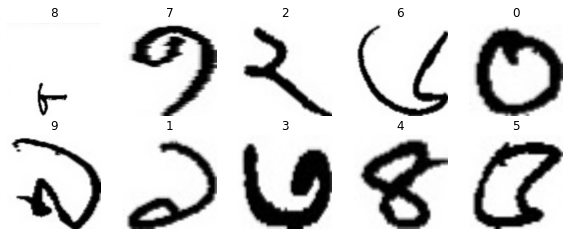

In [3]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Data Distribution of the Dataset 

c:\users\sabik\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


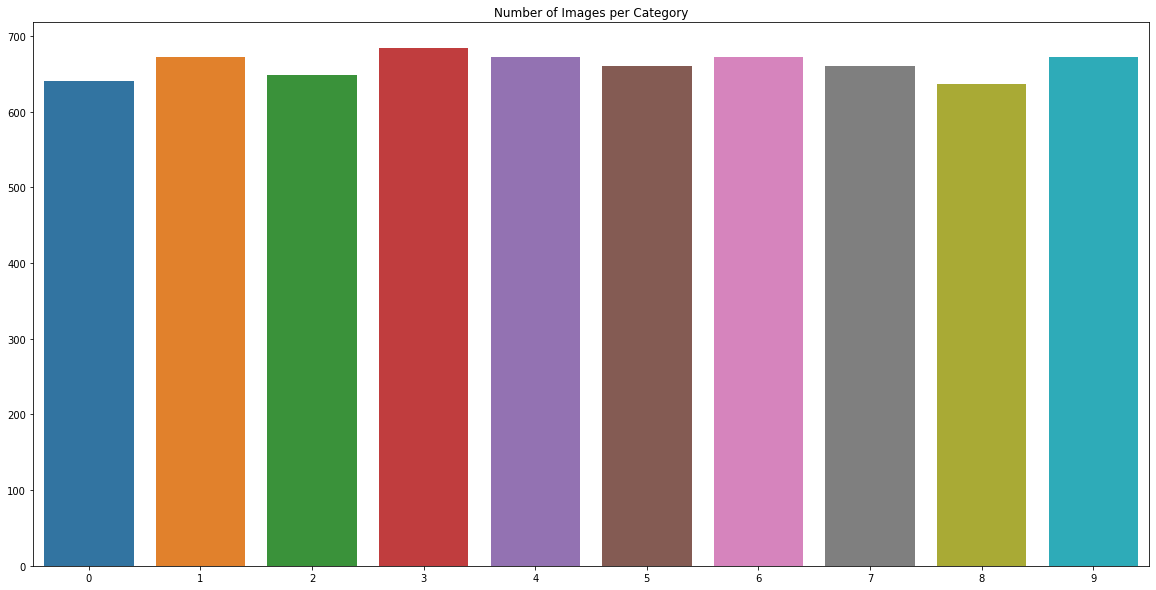

In [4]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(unique, count).set_title('Number of Images per Category')
plt.show()

In [5]:
# the dataset is not much imbalanced. So balancing is not required here much.

## Preprocessing the Data

In [6]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

6616


In [7]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

6616


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

print(len(Y_train))
print(len(Y_test))

5292
1324
5292
1324


## Data Distribution in Train

c:\users\sabik\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


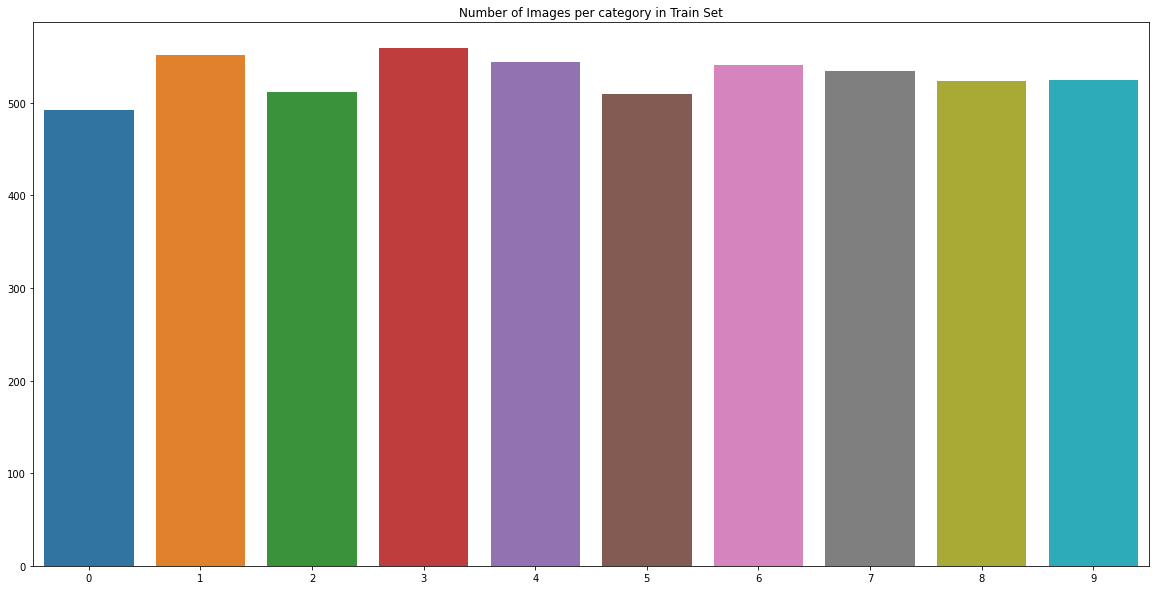

In [9]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(unique_train, count_train).set_title('Number of Images per category in Train Set')
plt.show()

## Data Distribution in Test Set

c:\users\sabik\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


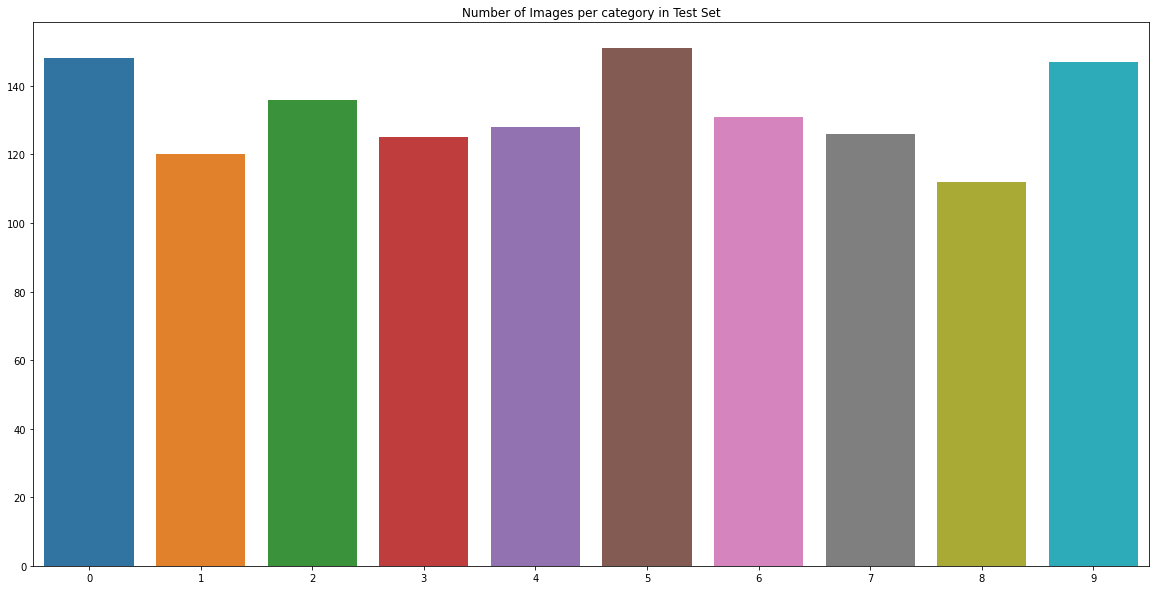

In [10]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(unique_test, count_test).set_title('Number of Images per category in Test Set')
plt.show()

## Defining the Model 

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5292, 32, 32, 1)
(1324, 32, 32, 1)
(5292, 10)
(1324, 10)


In [12]:
def digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(10, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [13]:
model = digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

##  Training the Model

In [14]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [15]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
42/42 [==============================] - 7s 140ms/step - loss: 3.7858 - accuracy: 0.3507 - val_loss: 2.3473 - val_accuracy: 0.7077
Epoch 2/100
42/42 [==============================] - 6s 131ms/step - loss: 1.5035 - accuracy: 0.7460 - val_loss: 1.2605 - val_accuracy: 0.8210
Epoch 3/100
42/42 [==============================] - 8s 187ms/step - loss: 0.9735 - accuracy: 0.8214 - val_loss: 1.0201 - val_accuracy: 0.8293
Epoch 4/100
42/42 [==============================] - 8s 188ms/step - loss: 0.7488 - accuracy: 0.8543 - val_loss: 0.8197 - val_accuracy: 0.8640
Epoch 5/100
42/42 [==============================] - 8s 192ms/step - loss: 0.6391 - accuracy: 0.8670 - val_loss: 0.7320 - val_accuracy: 0.8633
Epoch 6/100
42/42 [==============================] - 7s 155ms/step - loss: 0.5840 - accuracy: 0.8730 - val_loss: 0.6312 - val_accuracy: 0.8852
Epoch 7/100
42/42 [==============================] - 6s 140ms/step - loss: 0.5364 - accuracy: 0.8821 - val_loss: 0.6072 - val_accuracy: 0.8829

Epoch 58/100
42/42 [==============================] - 5s 128ms/step - loss: 0.1334 - accuracy: 0.9732 - val_loss: 0.2144 - val_accuracy: 0.9547
Epoch 59/100
42/42 [==============================] - 5s 126ms/step - loss: 0.1352 - accuracy: 0.9734 - val_loss: 0.2618 - val_accuracy: 0.9373
Epoch 60/100
42/42 [==============================] - 5s 121ms/step - loss: 0.1325 - accuracy: 0.9741 - val_loss: 0.1979 - val_accuracy: 0.9607
Epoch 61/100
42/42 [==============================] - 5s 120ms/step - loss: 0.1344 - accuracy: 0.9717 - val_loss: 0.2178 - val_accuracy: 0.9547
Epoch 62/100
42/42 [==============================] - 5s 122ms/step - loss: 0.1475 - accuracy: 0.9688 - val_loss: 0.2411 - val_accuracy: 0.9502
Epoch 63/100
42/42 [==============================] - 5s 118ms/step - loss: 0.1258 - accuracy: 0.9741 - val_loss: 0.2098 - val_accuracy: 0.9554
Epoch 64/100
42/42 [==============================] - 5s 116ms/step - loss: 0.1266 - accuracy: 0.9741 - val_loss: 0.1932 - val_accuracy:

##  Loss and Accuracy Plot

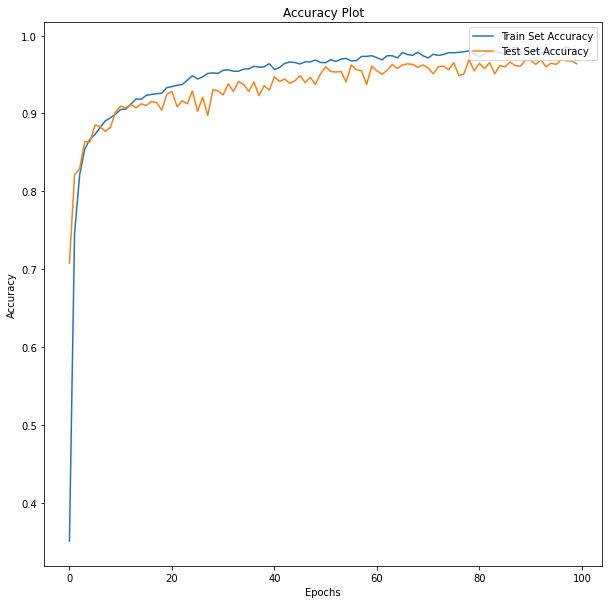

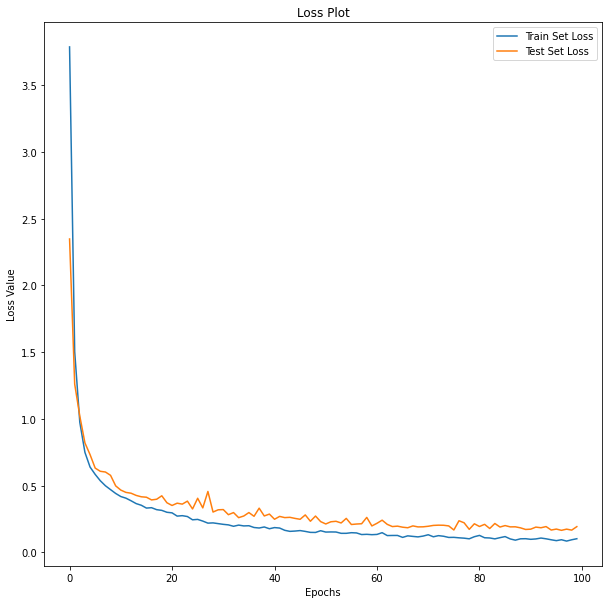

In [16]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

42/42 [==============================] - 0s 6ms/step


<AxesSubplot:>

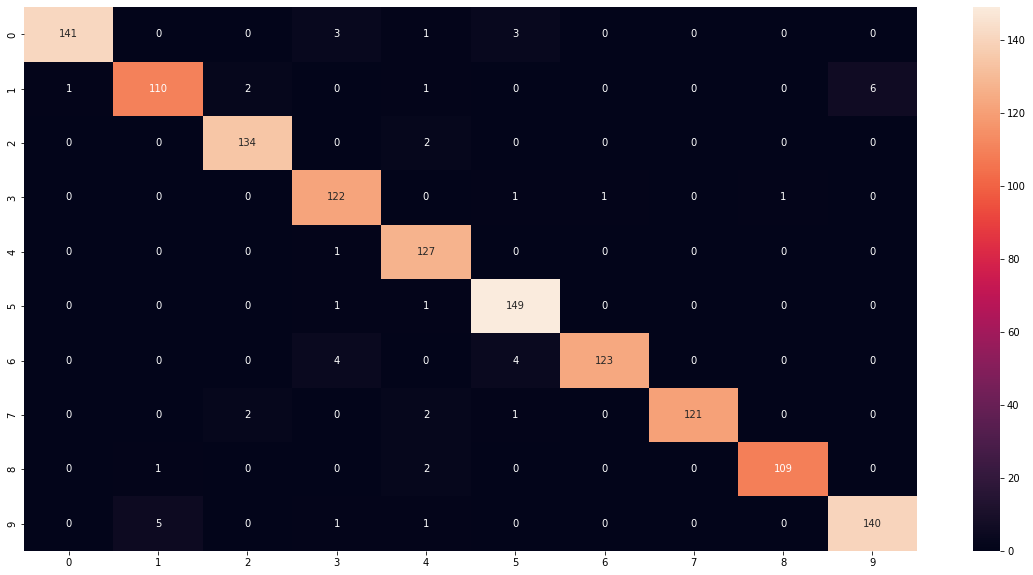

In [18]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [19]:
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       148
           1       0.95      0.92      0.93       120
           2       0.97      0.99      0.98       136
           3       0.92      0.98      0.95       125
           4       0.93      0.99      0.96       128
           5       0.94      0.99      0.96       151
           6       0.99      0.94      0.96       131
           7       1.00      0.96      0.98       126
           8       0.99      0.97      0.98       112
           9       0.96      0.95      0.96       147

    accuracy                           0.96      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.96      0.96      0.96      1324



## Saving the Model 

In [20]:
model.save('digits_recognition.h5')